## 6.2 プラットフォーム全体で観測される報酬を最適化する方策学習

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')

from dataset import generate_synthetic_data2
from policylearners import IPSBasedGradientPolicyLearner, CateBasedGradientPolicyLearner
from utils import softmax

### ログデータ(トレーニングデータ)のサイズ$n$を変化させたときの方策性能の変化

In [2]:
## シミュレーション設定
num_runs = 50 # シミュレーションの繰り返し回数
dim_x = 5 # 特徴量xの次元
num_actions = 10 # 行動数, |A|
beta = -0.1 # データ収集方策のパラメータ
max_iter = 21 # エポック数
test_data_size = 50000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)
num_actions_list = [2, 10] # 行動数
num_data_list = [100, 500, 1000, 2000] # トレーニングデータのサイズ

In [3]:
result_df_data_list = []
for num_actions in num_actions_list:
    ## 期待報酬関数を定義するためのパラメータを抽出
    theta_1 = random_.normal(size=(dim_x, num_actions))
    M_1 = random_.normal(size=(dim_x, num_actions))
    b_1 = random_.normal(size=(1, num_actions))
    theta_0 = random_.normal(size=(dim_x, num_actions))
    M_0 = random_.normal(size=(dim_x, num_actions))
    b_0 = random_.normal(size=(1, num_actions))
    ## 学習された方策の真の性能を近似するためのテストデータを生成
    test_data = generate_synthetic_data2(
        num_data=test_data_size, beta=beta,
        theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
        dim_context=dim_x, num_actions=num_actions, random_state = random_state
    )
    pi_0, q_x_a_1, q_x_a_0 = test_data["pi_0"], test_data["q_x_a_1"], test_data["q_x_a_0"]
    pi_0_value = (pi_0 * q_x_a_1 + (1. - pi_0) * q_x_a_0).sum(1).mean()

    result_df_list = []
    for num_data in num_data_list:
        test_policy_value_list = []
        for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
            ## データ収集方策が形成する分布に従いログデータを生成
            offline_logged_data = generate_synthetic_data2(
                num_data=num_data, beta=beta,
                theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
                dim_context=dim_x, num_actions=num_actions, random_state = _
            )

            true_value_of_learned_policies = dict()
            true_value_of_learned_policies["logging"] = pi_0_value

            ## ログデータを用いてオフ方策学習を実行する
            ### 勾配ベースのアプローチ (IPS推定量で方策勾配を推定)
            ips = IPSBasedGradientPolicyLearner(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            ips.fit(offline_logged_data, test_data)
            pi_ips = ips.predict(test_data)
            true_value_of_learned_policies["ips-pg"] = (pi_ips * q_x_a_1 + (1 - pi_ips) * q_x_a_0).sum(1).mean()
            ### 勾配ベースのアプローチ (新たに開発した推定量で方策勾配を推定)
            cate = CateBasedGradientPolicyLearner(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            cate.fit(offline_logged_data, test_data)
            pi_cate = cate.predict(test_data)
            true_value_of_learned_policies["cate-pg"] = (pi_cate * q_x_a_1 + (1 - pi_cate) * q_x_a_0).sum(1).mean()

            test_policy_value_list.append(true_value_of_learned_policies)

        ## シミュレーション結果の集計
        result_df = DataFrame(test_policy_value_list).stack().reset_index(1)\
            .rename(columns={"level_1": "method", 0: "value"})
        result_df["num_data"] = num_data
        result_df["pi_0_value"] = pi_0_value
        result_df["rel_value"] = result_df["value"] / pi_0_value
        result_df_list.append(result_df)
    result_df_data_list.append(pd.concat(result_df_list).reset_index(level=0))


num_data=2000...: 100%|██████████| 50/50 [04:21<00:00,  5.22s/it]


## 図6.10

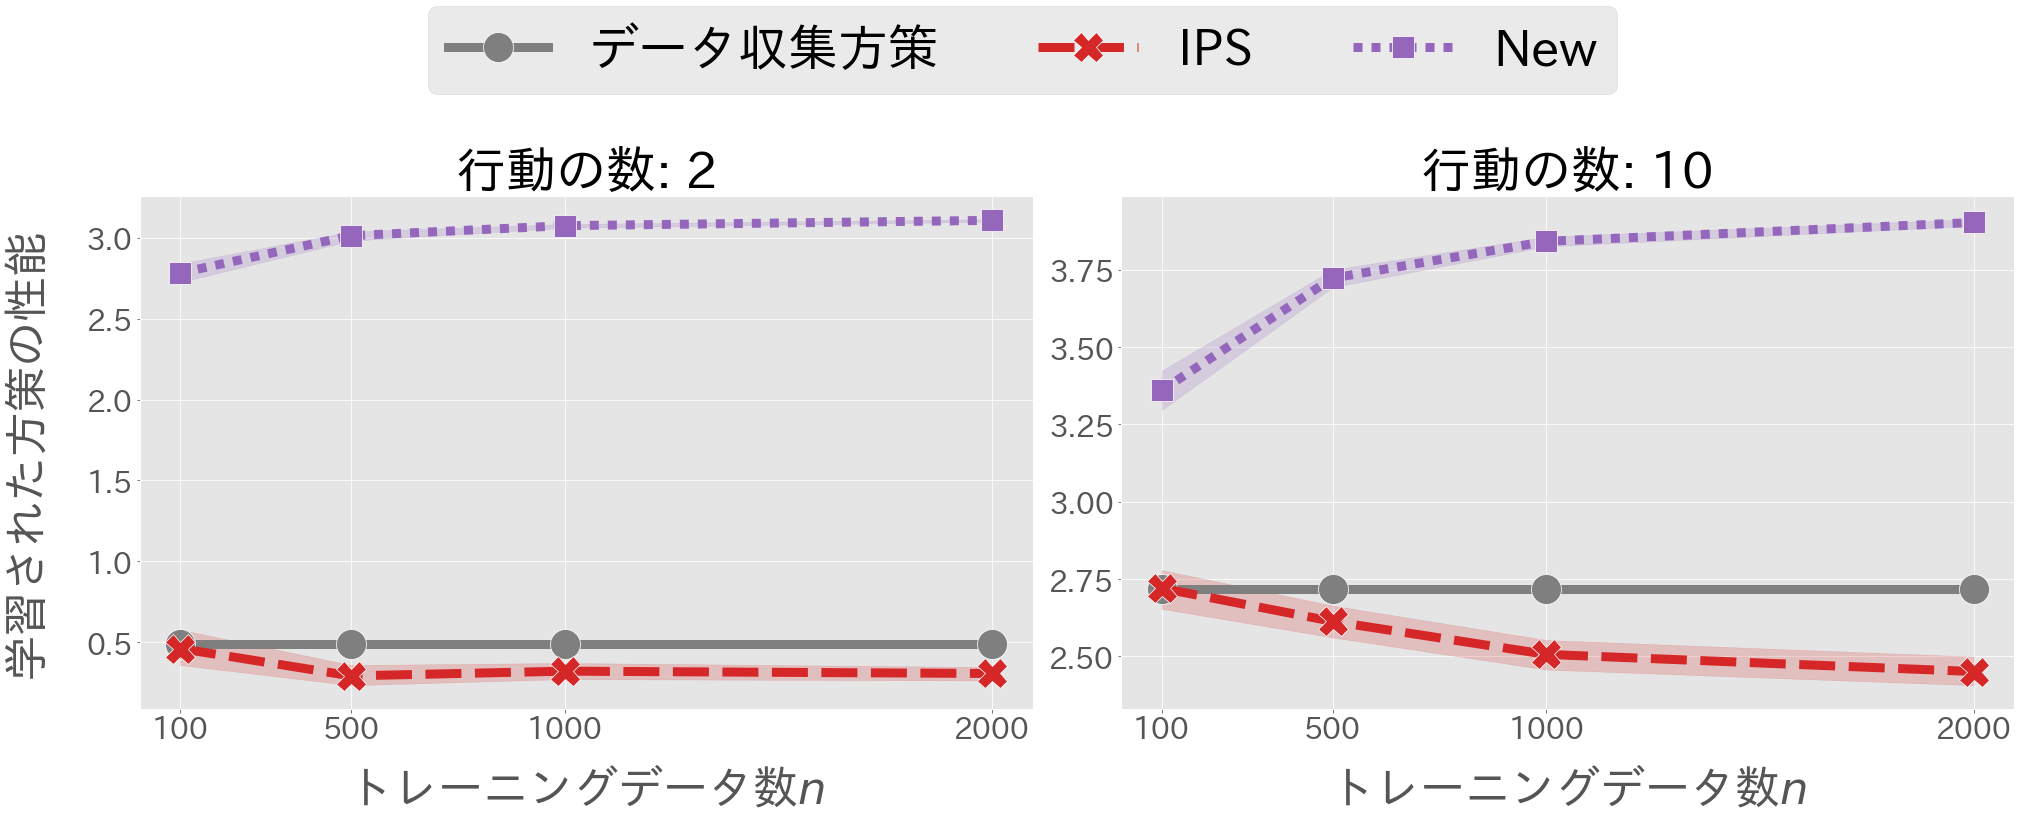

In [4]:
fig, ax_list = plt.subplots(1, 2, figsize=(28, 9.5), tight_layout=True)
for i, (num_actions, result_df) in enumerate(zip(num_actions_list, result_df_data_list)):
    ax = ax_list[i]
    sns.lineplot(
        linewidth=9,
        markersize=30,
        markers=True,
        x="num_data",
        y="value",
        hue="method",
        style="method",
        ax=ax,
        palette=["tab:grey", "tab:red", "tab:purple"],
        legend=False,
        data=result_df,
    )
    ax.set_title(f"行動の数: {num_actions}", fontsize=50)
    # yaxis
    if i == 0:
        ax.set_ylabel("学習された方策の性能", fontsize=45)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xlabel("トレーニングデータ数$n$", fontsize=45)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.11)
fig.legend(["データ収集方策", "IPS", "New"], fontsize=50, bbox_to_anchor=(0.5, 1.13), ncol=5, loc="center")


### ログデータ(トレーニングデータ)のサイズ$n$を変化させたときの学習曲線の変化

In [9]:
## シミュレーション設定
num_runs = 50 # シミュレーションの繰り返し回数
dim_x = 5 # 特徴量xの次元
num_actions = 10 # 行動数, |A|
beta = -0.1 # データ収集方策のパラメータ
max_iter = 21 # エポック数
test_data_size = 50000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)
num_data_list = [100, 500, 2000] # トレーニングデータのサイズ

In [10]:
## 期待報酬関数を定義するためのパラメータを抽出
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))
## 学習された方策の真の性能を近似するためのテストデータを生成
test_data = generate_synthetic_data2(
    num_data=test_data_size, beta=beta,
    theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
    dim_context=dim_x, num_actions=num_actions, random_state = random_state
)
pi_0, q_x_a_1, q_x_a_0 = test_data["pi_0"], test_data["q_x_a_1"], test_data["q_x_a_0"]
pi_0_naive_value = (pi_0 * q_x_a_1).sum(1).mean()
pi_0_cate_value = (pi_0 * q_x_a_1 + (1. - pi_0) * q_x_a_0).sum(1).mean()

curve_list_data = []
for num_data in num_data_list:
    curve = DataFrame()
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data2(
            num_data=num_data, beta=beta,
            theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
            dim_context=dim_x, num_actions=num_actions, random_state = _
        )

        log_ = DataFrame([
            [pi_0_naive_value] * max_iter, [pi_0_cate_value] * max_iter, ["logging"] * max_iter],
            index=["naive_value", "cate_value", "method"]
        ).T.reset_index()

        ## ログデータを用いてオフ方策学習を実行する
        ### 勾配ベースのアプローチ (IPS推定量で方策勾配を推定)
        ips = IPSBasedGradientPolicyLearner(
            dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
        )
        ips.fit(offline_logged_data, test_data)
        ips_ = DataFrame(
            [ips.naive_value, ips.cate_value, ["ips"] * max_iter],
            index=["naive_value", "cate_value", "method"]
        ).T.reset_index()
        ### 勾配ベースのアプローチ (新たに開発した推定量で方策勾配を推定)
        cate = CateBasedGradientPolicyLearner(
            dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
        )
        cate.fit(offline_logged_data, test_data)
        cate_ = DataFrame(
            [cate.naive_value, cate.cate_value, ["cate"] * max_iter],
            index=["naive_value", "cate_value", "method"]
        ).T.reset_index()

        curve = pd.concat([curve, pd.concat([log_, ips_, cate_])])
    curve.reset_index(inplace=True)
    curve_list_data.append(curve)

num_data=2000...: 100%|██████████| 50/50 [04:21<00:00,  5.23s/it]


## 図6.11

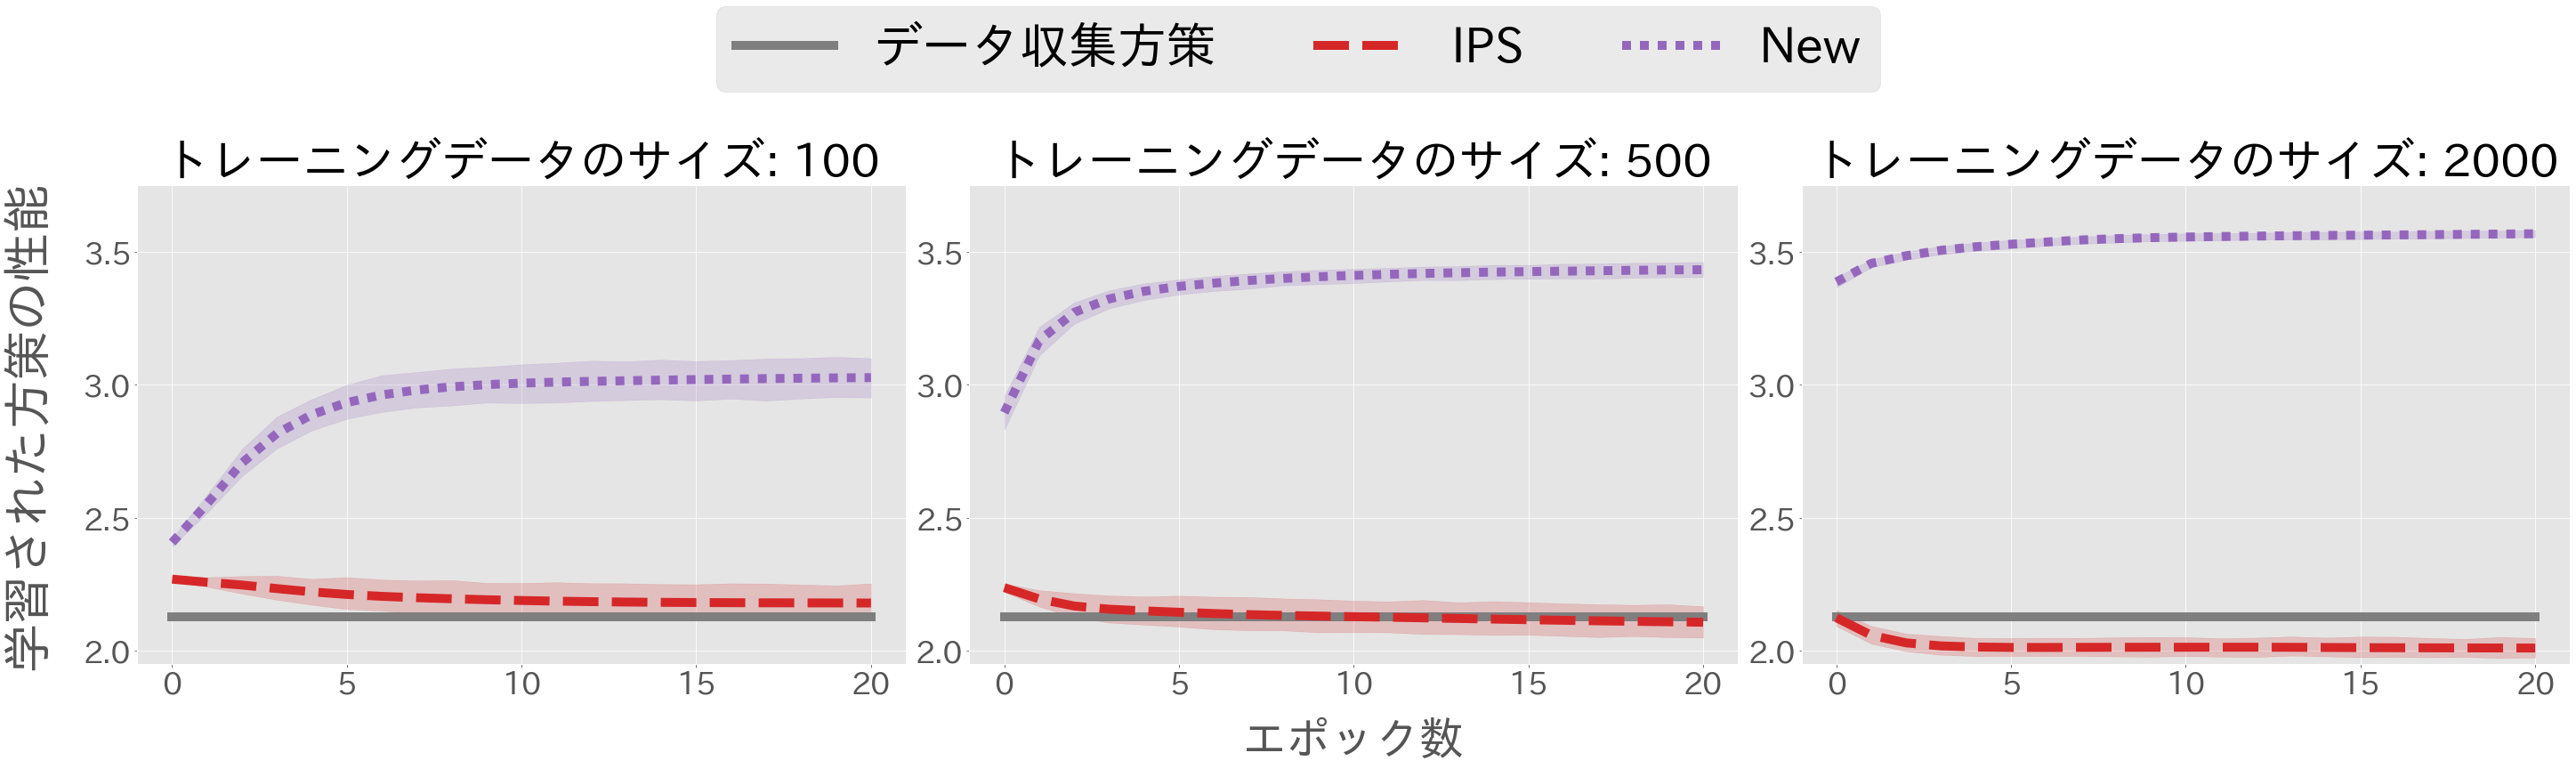

In [11]:
fig, ax_list = plt.subplots(1, 3, figsize=(40, 10), tight_layout=True)
for i, (num_data, curve) in enumerate(zip(num_data_list, curve_list_data)):
    ax = ax_list[i]
    sns.lineplot(
        linewidth=10,
        x="index",
        y="cate_value",
        hue="method",
        style="method",
        ax=ax,
        palette=["tab:grey", "tab:red", "tab:purple"],
        legend=False,
        data=curve.query("method != 'pocem'"),
    )
    ax.set_title(f"トレーニングデータのサイズ: {num_data}", fontsize=52)
    # yaxis
    if i == 0:
        ax.set_ylabel("学習された方策の性能", fontsize=55)
    else:
        ax.set_ylabel("", fontsize=45)
    ax.set_ylim(1.95, 3.75)
    ax.tick_params(axis="y", labelsize=35)
    ax.yaxis.set_label_coords(-0.11, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel("エポック数", fontsize=50)
    else:
        ax.set_xlabel("", fontsize=50)
    ax.tick_params(axis="x", labelsize=35)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["データ収集方策", "IPS", "New"], fontsize=55,
    bbox_to_anchor=(0.5, 1.13), ncol=5, loc="center",
)


## 図6.12

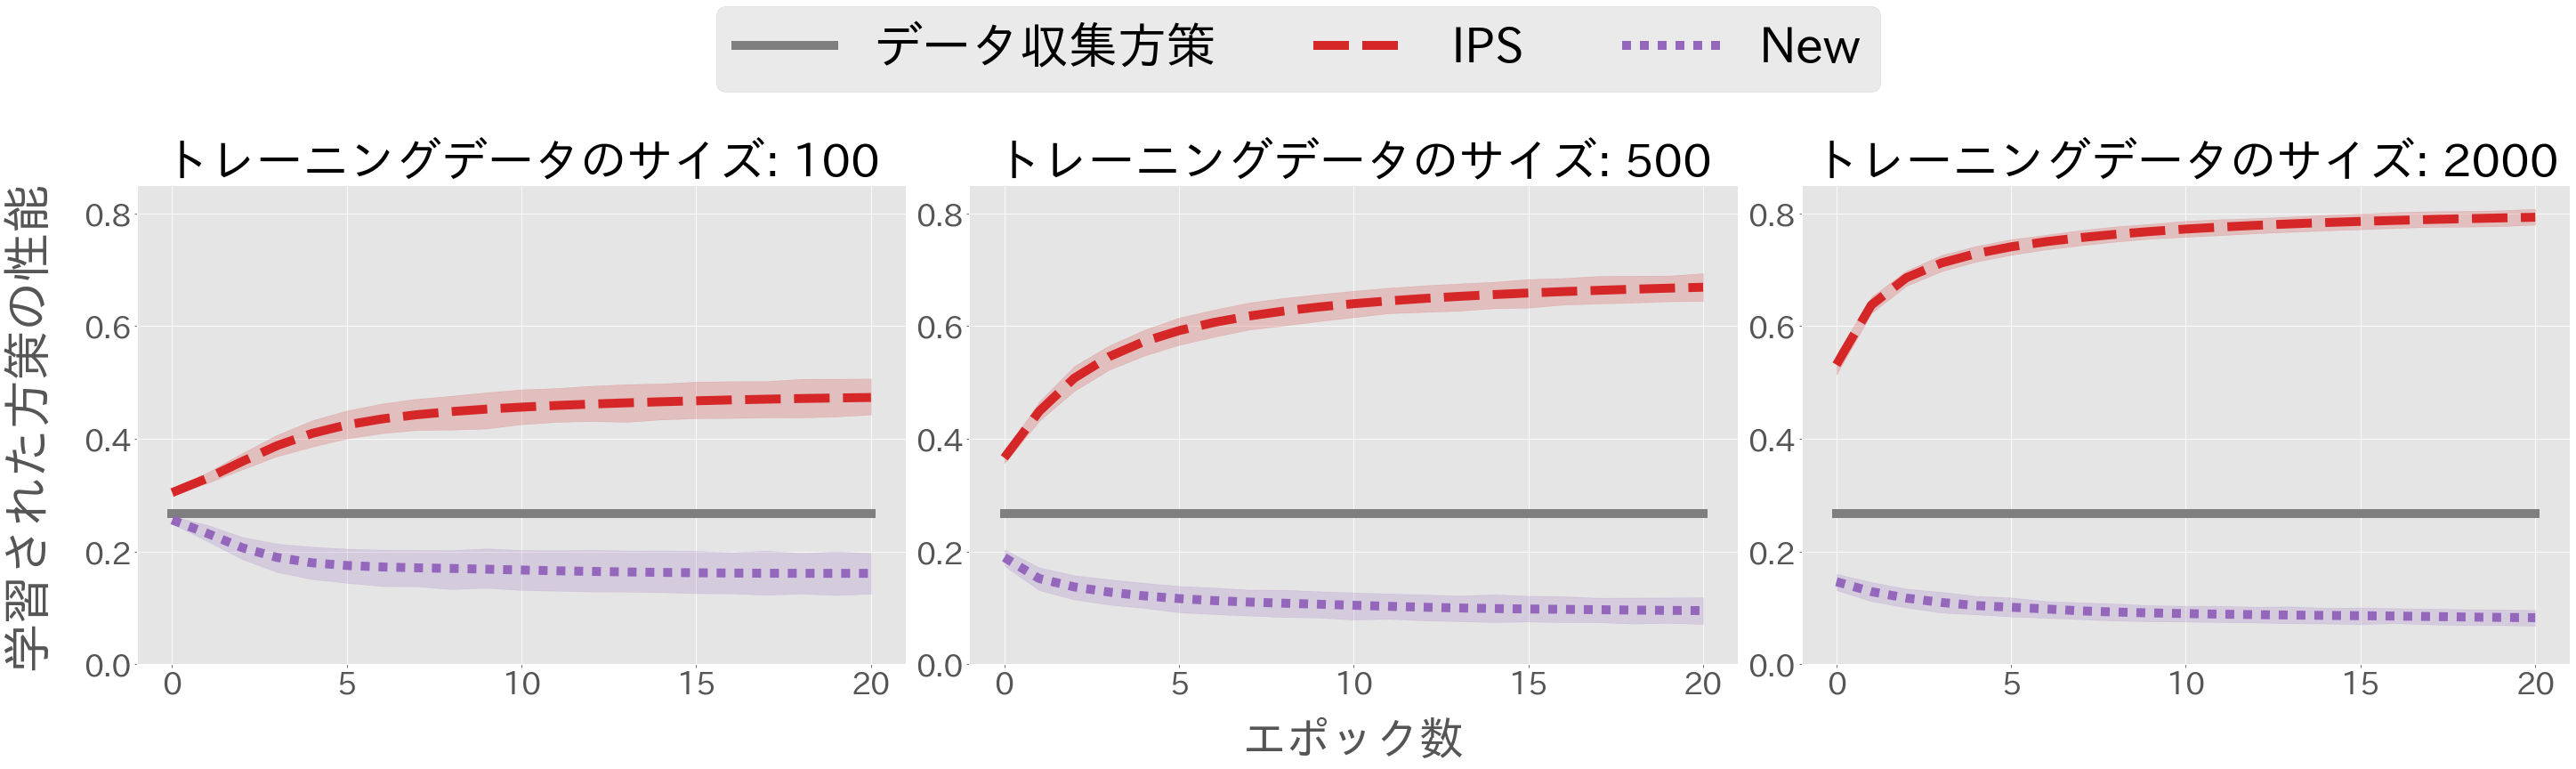

In [12]:
fig, ax_list = plt.subplots(1, 3, figsize=(40, 10), tight_layout=True)
for i, (num_data, curve) in enumerate(zip(num_data_list, curve_list_data)):
    ax = ax_list[i]
    sns.lineplot(
        linewidth=10,
        x="index",
        y="naive_value",
        hue="method",
        style="method",
        ax=ax,
        palette=["tab:grey", "tab:red", "tab:purple"],
        legend=False,
        data=curve.query("method != 'pocem'"),
    )
    ax.set_title(f"トレーニングデータのサイズ: {num_data}", fontsize=52)
    # yaxis
    if i == 0:
        ax.set_ylabel("学習された方策の性能", fontsize=55)
    else:
        ax.set_ylabel("", fontsize=45)
    ax.set_ylim(0.0, 0.85)
    ax.tick_params(axis="y", labelsize=35)
    ax.yaxis.set_label_coords(-0.11, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel("エポック数", fontsize=50)
    else:
        ax.set_xlabel("", fontsize=50)
    ax.tick_params(axis="x", labelsize=35)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["データ収集方策", "IPS", "New"], fontsize=55,
    bbox_to_anchor=(0.5, 1.13), ncol=5, loc="center",
)
